# PHYS 3317 -- Tunneling

Upload completed notebook to Blackboard at end of recitation section (or before next recitation if you do not complete it during the recitation period)

<font color="red"><em> Vineet Kamat </em></font>

This is a less-structured notebook.  Use the skills you have picked up last week to study the behavior of a wave-packet incident on a barrier. I highly recommend working together.

Work in units where $\hbar=m=1$ consider a box of length $L=40$, with hard wall boundary conditions.  Use a grid spacing $dx=0.02$.  
<ul>
<li> Create a potential which is zero, except for between $x=20$ to $x=20.2$, where the potential has height $V_0=800$. </li>
<li>Plot the potential. </li>
<li>Create a Gaussian wavepacket centered at $x=4$ with wave-vector $k=12\pi$ and width $\delta x=1$</li>
<li>Plot this wavepacket</li>
<li>Use the <em>tdseviewer</em> package to animate the time evolution of this wavepacket.  Use a timestep dt=0.0001, and integrate from time t=0 to time t=1.  Plot only one frame out of 100.  Store the time-series of the wavefunction.</li>
<li>You should find that the wave-packet splits into two, with one part passing through the barrier, and the other reflecting.</li>
<li>Analyze your stored time-series to calculate the probability that the wavepacket passes through the barrier.</li>
<li>Repeat for barriers with thicknesses 0.4 and 0.8.</li>
<li>Make a plot of the logarithm of the barrier penetration probability versus barrier thickness.</li>
</ul>

In [147]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/Users/vineetkamat/anaconda2/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['linalg']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [148]:
from __future__ import division  #get rid of integer division bug
from scipy.sparse import *  # loads the functions to deal with sparse matrices
from showmat import showmat # loads display functions 
# if you get an error message, download showmat.py and put in directory with notebooks

In [149]:
# you don't need to do anything here -- just hit shift-enter
def SecondDerivMatrix(numpoints,dx,periodic) : 
    """SecondDerivMatrix(numpoints,dx,periodic) returns a sparse matrix
    which represents the second derivative -- using a 3-point derivative.  

    It takes periodic needed arguments:
    numpoints -- an integer which is how many points are in the grid
    dx -- the real space lattice spacing
    periodic -- do we use periodic boundary conditions?

    Setting periodic to "False" will give "hard wall boundaries"
    """
    unitlist=ones(numpoints)  # just a list of 1's whose length is equal to the length of the grid
    if periodic :
        return dia_matrix(       # we are generating a sparse matrix by specifying the diagonals
            ((unitlist/(dx**2),unitlist/(dx**2),-2*unitlist/(dx**2),unitlist/(dx**2),unitlist/(dx**2)),
            (1,-1,0,numpoints-1,1-numpoints)),  # this line specifies which the diagonals
            shape=(numpoints,numpoints))
    else :
        return dia_matrix(       # we are generating a sparse matrix by specifying the diagonals
            ((unitlist/(dx**2),unitlist/(dx**2),-2*unitlist/(dx**2)),
            (1,-1,0)),  # this line specifies which the diagonals
            shape=(numpoints,numpoints))
    

In [150]:
def PotentialMatrix(potential):
    """PotentialMatrix(potential)
    generates a finite difference approximation to the operator V(x).
    It is called by the following arguments:
    potential -- the list of the potential values
    """

    ln=len(potential)
    return dia_matrix((potential,0),shape=(ln,ln))

In [198]:
def HamiltonianMatrix(potential,dx,periodic=True,hbar=1,mass=1):
    """HamiltonianMatrix(potential,dx,hbar=1,mass=1)
    generates a finite difference approximation to the hamiltonian operator H
    for the case of a single particle in a potential V(x)

    It is called by the following required arguments:
    potential -- a list of values for the potential
    dx -- the grid spacing
    
    It also has two optional arguments, which are assumed to be equal to unity if they
    are not specified
    hbar -- Planck's constant divided by 2 pi
    mass -- the particle mass
    """
    numpoints=len(potential)
    kin=-(0.5*hbar**2/mass)*SecondDerivMatrix(numpoints=numpoints,dx=dx,periodic=periodic) # calculate kinetic energy operator
    pot=PotentialMatrix(potential) #calculate potential energy operator
    return kin+pot

In [199]:
def PotentialMatrix(potential):
    """PotentialMatrix(potential)
    generates a finite difference approximation to the operator V(x).
    It is called by the following arguments:
    potential -- the list of the potential values
    """

    ln=len(potential)
    return dia_matrix((potential,0),shape=(ln,ln))

In [200]:
def wavepacket(xgrid,x,k,width):
    return exp(1.j*k*xgrid-(xgrid-x)**2/(2*width**2))

In [202]:
%gui tk  
# setup the ipython notebook so that it can generate graphics windows using the tk backend

In [231]:
import TDSEviewer3  # load the module that has the Schrodinger equation viewer
from TDSEviewer3 import *  # loads those functions into the main namespace

In [232]:
import scipy.sparse.linalg as linalg
import scipy.sparse as sparse

In [233]:
# Hit shift-enter to generate the functions needed to evolve the wavefunction
# This uses a very efficient linear-algebra algorithm known as LU decomposition

dt=0.001  # set time step

dx=0.01*pi  # set x step
xgrid=arange(0,pi,dx)  # generate grid
pot=zeros(len(xgrid))  # generate potential
hardwallham=HamiltonianMatrix(potential=pot,dx=dx,periodic=False) #make Hamiltonian

csrham=csc_matrix(hardwallham)                              # convert to more efficient format
hamsize=hardwallham.shape[0]                                # figure out how big the matrix is
LHSOperator=sparse.identity(hamsize,dtype=complex,format="csc")+0.5j*dt*csrham # Operator on Left
inverseLHS=linalg.factorized(LHSOperator) # A function which essentially acts like the inverse matrix
RHSOperator=sparse.identity(hamsize,dtype=complex,format="csc")-0.5j*dt*csrham # Operator on right

In [234]:
# Fill in the missing code

class tdse:
    """ tdse generates the machinery for evolving a wavefunction.  Call it with
    tdse(dt,dx,pot,periodic): dt is the timestep, dx is the spatial discretization,
    pot is a list of values of the potential on the grid.  periodic is True or False,
    depending on if you want periodic boundary conditions"""
    
    def __init__(self,dt,dx,pot,periodic=False):
        self.dt=dt
        self.dx=dx
        self.pot=pot
        self.periodic=periodic
        self.ham=HamiltonianMatrix(potential=pot,dx=dx,periodic=periodic)
        

        self.csrham= csc_matrix(self.ham) 
        self.hamsize= self.ham.shape[0] 
        self.LHSOperator = sparse.identity(self.hamsize,dtype=complex,format="csc")+0.5j*self.dt*self.csrham  
        self.inverseLHS= linalg.factorized(self.LHSOperator) #insert code to generate LU factorized operator for inverting matrix
        self.RHSOperator = sparse.identity(self.hamsize,dtype=complex,format="csc")-0.5j*self.dt*self.csrham  #insert code to form operator on right
        
    def evolve(self,wavefunction):
        return self.inverseLHS(self.RHSOperator.dot(wavefunction))

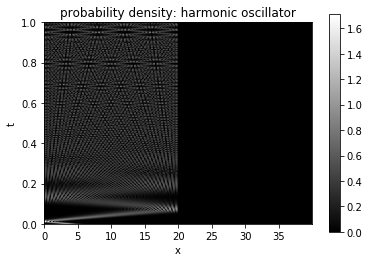

In [261]:

wf = wavepacket(xgrid,x=4,k=12*pi,width=1)
pot = zeros(len(wf))
pot[200:202] = 800
dx = .1
xgrid = arange(0,40,dx)
free=tdse(dt=0.01,dx=dx,pot=pot)
dt = .0001



viewer=TDSEviewer(wavefunction=wf,grid=xgrid,potential=pot)
viewer.set_geometry(1000,500)


timeseries=[] # list which will contain the wavefunctions

counter=0
t=0.

# loop over timesteps
while t<1:
    if counter%100==0:
        viewer.updatelines()
        viewer.set_title(t)
    timeseries.append([t,viewer.wavefunction])
    viewer.wavefunction=free.evolve(viewer.wavefunction)
    t=t+dt
    counter=counter+1
    
wfseries=array([wf for time,wf in timeseries])
xlim([xgrid[0],xgrid[-1]])
ylim([0,t])
imshow(abs(wfseries),aspect=30,origin="lower",cmap=gray(),extent=[xgrid[0],xgrid[-1],0,t])
title("probability density: harmonic oscillator")
ylabel("t")
xlabel("x")
colorbar()
#uncomment the next line to save the figure
savefig("pdens.png")

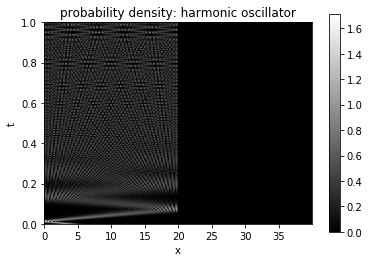

In [263]:

wf = wavepacket(xgrid,x=4,k=12*pi,width=1)
pot = zeros(len(wf))
pot[200:204] = 800
dx = .1
xgrid = arange(0,40,dx)
free=tdse(dt=0.01,dx=dx,pot=pot)
dt = .0001



viewer=TDSEviewer(wavefunction=wf,grid=xgrid,potential=pot)
viewer.set_geometry(1000,500)


timeseries=[] # list which will contain the wavefunctions

counter=0
t=0.

# loop over timesteps
while t<1:
    if counter%100==0:
        viewer.updatelines()
        viewer.set_title(t)
    timeseries.append([t,viewer.wavefunction])
    viewer.wavefunction=free.evolve(viewer.wavefunction)
    t=t+dt
    counter=counter+1
    
wfseries=array([wf for time,wf in timeseries])
xlim([xgrid[0],xgrid[-1]])
ylim([0,t])
imshow(abs(wfseries),aspect=30,origin="lower",cmap=gray(),extent=[xgrid[0],xgrid[-1],0,t])
title("probability density: harmonic oscillator")
ylabel("t")
xlabel("x")
colorbar()
#uncomment the next line to save the figure
savefig("pdens2.png")

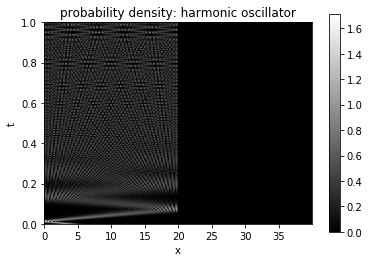

In [264]:

wf = wavepacket(xgrid,x=4,k=12*pi,width=1)
pot = zeros(len(wf))
pot[200:208] = 800
dx = .1
xgrid = arange(0,40,dx)
free=tdse(dt=0.01,dx=dx,pot=pot)
dt = .0001



viewer=TDSEviewer(wavefunction=wf,grid=xgrid,potential=pot)
viewer.set_geometry(1000,500)


timeseries=[] # list which will contain the wavefunctions

counter=0
t=0.

# loop over timesteps
while t<1:
    if counter%100==0:
        viewer.updatelines()
        viewer.set_title(t)
    timeseries.append([t,viewer.wavefunction])
    viewer.wavefunction=free.evolve(viewer.wavefunction)
    t=t+dt
    counter=counter+1
    
wfseries=array([wf for time,wf in timeseries])
xlim([xgrid[0],xgrid[-1]])
ylim([0,t])
imshow(abs(wfseries),aspect=30,origin="lower",cmap=gray(),extent=[xgrid[0],xgrid[-1],0,t])
title("probability density: harmonic oscillator")
ylabel("t")
xlabel("x")
colorbar()
#uncomment the next line to save the figure
savefig("pdens3.png")